# ORF MLP  
Trying to fix bugs.  
NEURONS=128 and K={1,2,3}.  


In [13]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-25 20:40:39 UTC


In [14]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=8000
NC_TESTS=8000   
RNA_LEN=1000  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.01
EPOCHS=100 # 1000 # 200
SPLITS=5
FOLDS=5   # make this 5 for serious testing

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [16]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator, Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator, Transcript_Oracle
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel"  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data Load


In [17]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")

2021-07-25 20:40:40 UTC
Generated 16000 PC seqs
Generated 16000 NC seqs


In [18]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)
show_time()

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 1000.0
Average ORF length: 675.05625
NC seqs
Average RNA length: 1000.0
Average ORF length: 180.3455625
2021-07-25 20:41:00 UTC


## Data Prep

In [19]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None
print("First PC train",pc_train[0])
print("First PC test",pc_test[0])

PC train, NC train: 8000 8000
PC test, NC test: 8000 8000
First PC train GCCGAAGCGTCTGTTTTCGCACGCTCAGCCATGTCTAACCCTCCCCACTGCGTGGGAATTCCTTCCCCCGTATAGCCTTGCCTGCCAAGGTCTCGACGCTCACGCCGAAGCCGCCGTAGATGCCATTTCATGAAGATCCTGACCTAGACTTGACAATTTTAGATATGTACCGGTATTGCGCGTGTGCATCCCCCCACCGCCTTCTGCGTAGGCATTACGCTATGATTCTTAACAATGGGGTAACAAGAGAAGTTTGCAAAGACACAATGTGCGATCCTCCACCTAAATGTATCCTGGCAGCACCATCACCGCGCATGGTAGTCTTGTCGGGTACGTTTCGGCTTGGCACGATTGTAATCGTGCGCTCCATCCACCTCCCCTCTACAGTTAGATCTGCCGTGAAAGAAGTCAATTTCCAATACCGGTATCGAATAGACATCGGCGATTGCAACAAAAACACTCGAAGCTATGCCAGTGCAAGGACCGTGACTAAGCCAAGCATCGTTCGGTGGTCAGGAAGACATGCCCAAGTCCCCAGCTTTAATGGTACTTCGCCCGGGAATTTCGATACCACCTGGGCTCTCTCGCCTAGATCCAGACCTCCAGCGGCGAATCTTCACAACGACTTGTGTATGCTGGTGTGCGACCGGTTTAATAAAATCTCGAGCCAGTTTGTGATCCCTAGGTCGGTGTCGACGCGGATGAATTATGAGGCAGTGGTTCAACGGGCACTGACACAAGCAGTTAGTAGGTCCACCACGCCGGTTATTACTGGAAGGTGGAGGGTCAAACTGTGTCAAGTTTACATGCCAACCACCCTGAAGTATCTTCATGTTAATTCAACGCGGTATTTCAAAGCTCCCGACTCAGACCCAGGGTGAAAGATTCCAGGTGTAACGAGTCACTGACGAAGAATCTCAGGCCGGG

In [20]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    for i in range(0,len0):
        all_labels[i*2] = L0[i]
        all_seqs[i*2] = S0[i]
        all_labels[i*2+1] = L1[i]
        all_seqs[i*2+1] = S1[i]
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[:3])
print(y[:3])
# Tests:
show_time()

['TGTCCAGTATATGCGCCGAGGGGTCGCGTGCCGTCCAAATCACCTGATGCATAAAGAACGCGTTAGGAAAAATTCGGTTGGGCAGTGCGATACACTTTTAAGTCTAGGTGCACGACTCCGATTCGATGGTTGCCAACGAGGGCTACTTATGAACTATTTTGGGCTGCCCGCTAGATCTGCAAGCGTACCTTAGAATATACGCCACCAACGATCAAGCGTGTCTCCCGGGTCTGTCTGTTCATCCCCGAAGTAAGTATGCGACCGGACTTTGTCTTTGCATAAAAGGGGTGCGCAGACCCCCACGCAAAAGGGCCTGGTGGAAAAAAGGCTTCGGATTGTAAACTAAATGACGGCTGCTTTTGATAGCAGATTGAACCTGTTGGGTCCAAAATCTCCAGAGTTGGCGCGGACGGTGCGTTGTAATGTTGTTACAACCTAGTTTCACTTATACATCGGACTTAGAGAGAAATCACGTGAATTTTGCGTGAACCATGGCGTAGCTGTATTCCACGAGTGAGGTTCTGGGACTTCACGTTCGACCATCAATCTGTCGCATTCTACCGATAGGTCTCGGCTATTGTAACGTAGCATTATTATCTTAGTCACGGAACCTTTATGAGGCGCCAAAAGAGCTACATCGCCGTGAGGTCGCGTTTTCCTCCGTCTGTACTATAGTATCCTCACTTGCAGATCCACGGGAAATCTAGTGAAGACGTACGTCCCTTAACCGTGATATCGTTGATGAGAATTCCTGGGTATCACGTCTGCCCAGAGGTCTCATGTGTGCGTGCACAGAGTCGTGACCCGTTAGTATAATTTCTTCATGTATAGAGAGGTTTCTTTTGCTGCACTAGATCAGAGGATCGTAGGATTTTTGCAGCTGCTGCATCAATAAGTGCAATTGGCGGAAGCTTAACCGATCGTTAGGCAAGACTCCACTGGAACTTGCCGGGTCGACAGATACGCTGGAAATGCTCCTGGGTAAGCGTGCACACAAA

In [21]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    collection = []
    for seq in seqs:
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[:3])
show_time()

[[0.247      0.23       0.256      0.267      0.06806807 0.05605606
  0.06006006 0.06306306 0.05505506 0.05005005 0.06506507 0.05905906
  0.06406406 0.06106106 0.05805806 0.07307307 0.06006006 0.06306306
  0.07307307 0.07107107 0.0240481  0.01402806 0.01503006 0.01503006
  0.00801603 0.01402806 0.01803607 0.01503006 0.02104208 0.00901804
  0.01603206 0.01402806 0.01503006 0.02004008 0.01302605 0.01503006
  0.01402806 0.01803607 0.01102204 0.01202405 0.01503006 0.01002004
  0.01402806 0.01102204 0.01402806 0.01302605 0.01302605 0.0250501
  0.01202405 0.00901804 0.02004008 0.01803607 0.01703407 0.01302605
  0.01603206 0.01803607 0.01803607 0.01002004 0.01803607 0.01503006
  0.01402806 0.01202405 0.01503006 0.01703407 0.01803607 0.01903808
  0.01903808 0.01703407 0.01302605 0.01102204 0.01803607 0.01803607
  0.01402806 0.01603206 0.01503006 0.01803607 0.01503006 0.02705411
  0.01402806 0.01703407 0.01503006 0.01503006 0.02004008 0.02104208]
 [0.244      0.274      0.239      0.243      0.

## Neural network

In [22]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               10880     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    #mycallbacks = [ModelCheckpoint(
    #    filepath=MODELPATH, save_best_only=True, 
    #    monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    splitter = KFold(n_splits=SPLITS,shuffle=True) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    # callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-07-25 20:41:10 UTC
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 4ms/step - loss: 0.7090 - accuracy: 0.5057 - val_loss: 0.6931 - val_accuracy: 0.4953
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6962 - accuracy: 0.5065 - val_loss: 0.6985 - val_accuracy: 0.5047
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6944 - accuracy: 0.5142 - val_loss: 0.7140 - val_accuracy: 0.4953
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.5208 - val_loss: 0.6871 - val_accuracy: 0.5738
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6905 - accuracy: 0.5278 - val_loss: 0.6842 - val_accuracy: 0.4991
Epoch 6/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6831 - accuracy: 0.5569 - val_loss: 0.6789 - val_accuracy: 0.5097
Epoch 7/100
400/400 [==============================] - 1s 3ms/step - loss: 

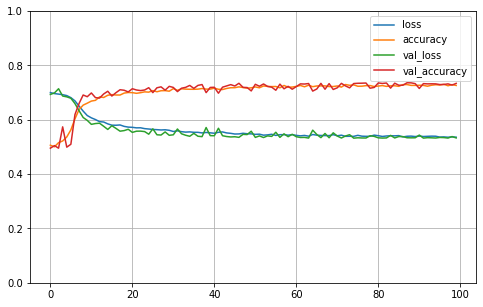

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 3s 4ms/step - loss: 0.7022 - accuracy: 0.4913 - val_loss: 0.6951 - val_accuracy: 0.5013
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6966 - accuracy: 0.4931 - val_loss: 0.6922 - val_accuracy: 0.5013
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6978 - accuracy: 0.5059 - val_loss: 0.6974 - val_accuracy: 0.5013
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.5106 - val_loss: 0.6891 - val_accuracy: 0.4988
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6907 - accuracy: 0.5248 - val_loss: 0.6844 - val_accuracy: 0.5053
Epoch 6/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.5331 - val_loss: 0.6770 - val_accuracy: 0.5447
Epoch 7/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6783 - accuracy: 0.567

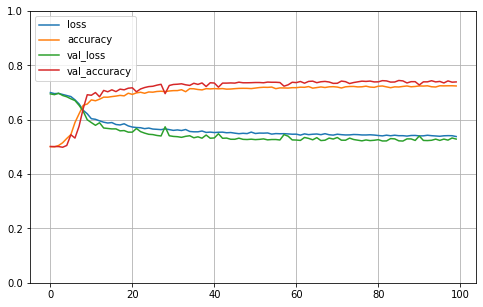

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 3s 5ms/step - loss: 0.6985 - accuracy: 0.5112 - val_loss: 0.6982 - val_accuracy: 0.4894
Epoch 2/100
400/400 [==============================] - 1s 4ms/step - loss: 0.6976 - accuracy: 0.5028 - val_loss: 0.6914 - val_accuracy: 0.5141
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6944 - accuracy: 0.5108 - val_loss: 0.6898 - val_accuracy: 0.5106
Epoch 4/100
400/400 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.5113 - val_loss: 0.7030 - val_accuracy: 0.4894
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6907 - accuracy: 0.5351 - val_loss: 0.6803 - val_accuracy: 0.6431
Epoch 6/100
400/400 [==============================] - 1s 4ms/step - loss: 0.6810 - accuracy: 0.5727 - val_loss: 0.6737 - val_accuracy: 0.5666
Epoch 7/100
400/400 [==============================] - 1s 4ms/step - loss: 0.6704 - accuracy: 0.594

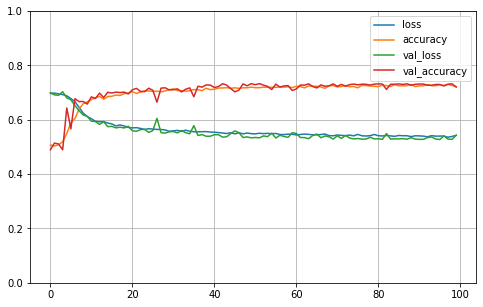

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 3s 4ms/step - loss: 0.6987 - accuracy: 0.4963 - val_loss: 0.6947 - val_accuracy: 0.5100
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6966 - accuracy: 0.4954 - val_loss: 0.7093 - val_accuracy: 0.5100
Epoch 3/100
400/400 [==============================] - 1s 4ms/step - loss: 0.6980 - accuracy: 0.5064 - val_loss: 0.6901 - val_accuracy: 0.5100
Epoch 4/100
400/400 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.5132 - val_loss: 0.7070 - val_accuracy: 0.4900
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6915 - accuracy: 0.5267 - val_loss: 0.6825 - val_accuracy: 0.6844
Epoch 6/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6846 - accuracy: 0.5646 - val_loss: 0.6781 - val_accuracy: 0.5163
Epoch 7/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6784 - accuracy: 0.562

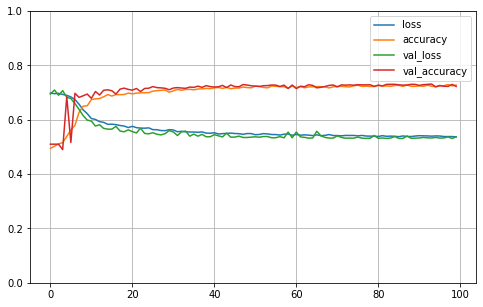

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 3s 4ms/step - loss: 0.6971 - accuracy: 0.5060 - val_loss: 0.6946 - val_accuracy: 0.5028
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6979 - accuracy: 0.4985 - val_loss: 0.7008 - val_accuracy: 0.5028
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6965 - accuracy: 0.5046 - val_loss: 0.6932 - val_accuracy: 0.5028
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6934 - accuracy: 0.5205 - val_loss: 0.6880 - val_accuracy: 0.5028
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6877 - accuracy: 0.5435 - val_loss: 0.6798 - val_accuracy: 0.5672
Epoch 6/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6831 - accuracy: 0.5539 - val_loss: 0.6742 - val_accuracy: 0.5194
Epoch 7/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6668 - accuracy: 0.604

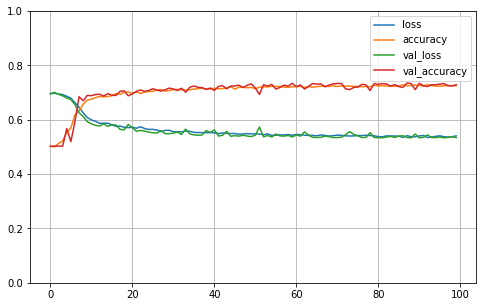

In [24]:
show_time()
last_model = do_cross_validation(Xfrq,y)

In [25]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
Prepare...
2021-07-25 20:52:57 UTC
Extract K-mer features...
2021-07-25 20:52:58 UTC
Plot...
2021-07-25 20:53:07 UTC


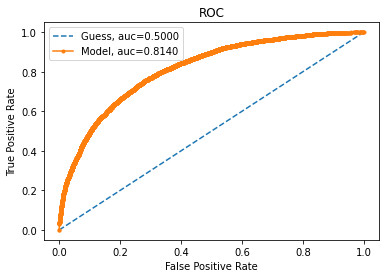

AUC: 81.40%
accuracy: 73.27%
2021-07-25 20:53:09 UTC


In [26]:
print("Accuracy on training data.")
print("Prepare...")
show_time()
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print("Extract K-mer features...")
show_time()
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("Plot...")
show_time()
show_test_AUC(last_model,Xfrq,y)
show_test_accuracy(last_model,Xfrq,y)
show_time()

Accuracy on test data.
Prepare...
2021-07-25 20:53:09 UTC
Extract K-mer features...
2021-07-25 20:53:09 UTC
Plot...
2021-07-25 20:53:19 UTC


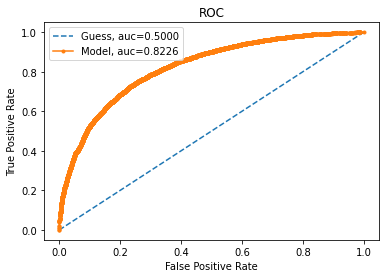

AUC: 82.26%
accuracy: 74.50%
2021-07-25 20:53:20 UTC


In [27]:
print("Accuracy on test data.")
print("Prepare...")
show_time()
Xseq,y=prepare_x_and_y(pc_test,nc_test)
print("Extract K-mer features...")
show_time()
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("Plot...")
show_time()
show_test_AUC(last_model,Xfrq,y)
show_test_accuracy(last_model,Xfrq,y)
show_time()